In [6]:
from typing_extensions import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langgraph.types import Send
from PyPDF2 import PdfReader
from operator import add


llm = init_chat_model("openai:gpt-5-nano-2025-08-07")

In [7]:
class State(TypedDict):
    document: str
    final_summary: str
    summaries: Annotated[list[dict], add]


In [8]:
def summarize_content(args):
    content = args["content"]
    index = args["index"]
    response = llm.invoke(f"Write a summary of the following document: {content}")

    return {
        "summaries": [
            {
                "summary": response.content,
                "index": index,
            },
        ]
    }


def dispatch_summarizers(state: State):
    # 더 작은 단위로 분할 (문장 단위 또는 단어 수 기준)
    import re

    # 문장 단위로 분할
    sentences = re.split(r"(?<=[.!?])\s+", state["document"])

    # 청크 크기 제한 (예: 5-10문장씩)
    chunk_size = 8
    chunks = []
    current_chunk = []

    for sentence in sentences:
        current_chunk.append(sentence)
        if len(current_chunk) >= chunk_size:
            chunks.append(" ".join(current_chunk))
            current_chunk = []

    # 남은 문장들 추가
    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return [
        Send("summarize_content", {"content": chunk, "index": i})
        for i, chunk in enumerate(chunks)
        if chunk.strip()
    ]


def final_summary(state: State):
    response = llm.invoke(
        f"Write a final summary of the following summaries: {state['summaries']}"
    )

    return {"final_summary": response.content}


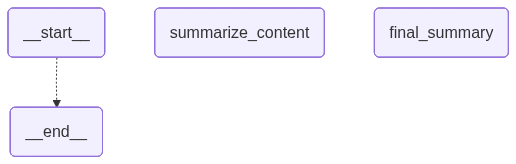

In [9]:
graph_builder = StateGraph(State)

graph_builder.add_node("summarize_content", summarize_content)
graph_builder.add_node("final_summary", final_summary)


graph_builder.add_conditional_edges(
    START,
    dispatch_summarizers,
    "summarize_content",
)

graph_builder.add_edge("summarize_content", "final_summary")
graph_builder.add_edge("final_summary", END)


graph = graph_builder.compile()

graph


In [10]:
with open("2025-National-Security-Strategy.pdf", "rb") as f:
    pdf_reader = PdfReader(f)
    document = ""
    for page in pdf_reader.pages:
        document += page.extract_text()


for chunk in graph.stream({"document": document}, stream_mode="updates"):
    print(chunk, "\n")

{'summarize_content': {'summaries': [{'summary': 'Summary:\nThe document argues that American national power rests on a strong industrial base, including sufficient defense production and defense-related capacity, and that cultivating industrial strength should be a top national economic priority. It envisions a highly robust and innovative energy sector that can drive domestic growth and become a leading export industry. It also stresses maintaining the United States as the world’s most scientifically and technologically advanced nation, protecting intellectual property from foreign theft, and preserving the American pioneering spirit as essential to economic dominance and military superiority. Finally, it highlights sustaining unrivaled soft power to positively influence the world in the nation’s interests.', 'index': 10}]}} 

{'summarize_content': {'summaries': [{'summary': 'The excerpt argues that American elites miscalculated the public’s willingness to bear long-term global burde